# Basics of Deep Learning

In [ ]:
student_id = 400101515 #@param {type:"integer"}
student_name = "Mahdi Tabatabei" #@param {type:"string"}

When completing the notebook, please adhere to the following rules:
- Do not write or modify any code outside of code blocks
- Do not add or delete any cells from the notebook. You may add new cells to perform scatch work, but delete them before submitting.
- Run all cells before submitting. You will only get credit for code that has been run.

Run the following cell to mount your Google Drive. Follow the link, sign in to your Google account (the same account you used to store this notebook).

In [1]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# TODO: Enter the foldername in your Drive where you have saved the
# assignment files, e.g. 'DL/assignments/assignment1/'
FOLDERNAME = "Q3-kNN"
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

The dataset for this exercise is CIFAR-10. Let's first download it then we'll explore it.

In [3]:
# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd /content/drive/My\ Drive/$FOLDERNAME/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

/content/drive/My Drive/Q3-kNN/datasets
/content/drive/My Drive/Q3-kNN


In [4]:
import os
import pytz
from datetime import datetime

# The file path
GOOGLE_DRIVE_PATH = '/content/drive/My Drive/{}'.format(FOLDERNAME)
pytorch_path = os.path.join(GOOGLE_DRIVE_PATH, 'k_nearest_neighbor.py')

# Get the last modified time in UTC
last_modified_time = os.path.getmtime(pytorch_path)
utc_time = datetime.utcfromtimestamp(last_modified_time)

# Define Iran's time zone
iran_tz = pytz.timezone('Asia/Tehran')

# Convert UTC time to Iran time
iran_time = pytz.utc.localize(utc_time).astimezone(iran_tz)

# Print the result in Iran's local time
print(f"k_nearest_neighbor.py last edited on: {iran_time.strftime('%Y-%m-%d %H:%M:%S')}")

k_nearest_neighbor.py last edited on: 2024-10-21 20:38:23


# k-Nearest Neighbor (kNN)

The kNN classifier consists of two stages:

- During training, the classifier takes the training data and simply remembers it
- During testing, kNN classifies every test image by comparing to all training images and transfering the labels of the k most similar training examples
- The value of k is cross-validated

You will implement these steps in this notebook and understand the basic Image Classification pipeline, cross-validation, and gain proficiency in writing efficient, vectorized code.

The following code is to setup the enviroment

In [5]:
import random
import numpy as np
from data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is to make matplotlib figures appear inline in the notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# This is here so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [6]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

In [7]:
################################################################################
# TODO:                                                                        #
# As a sanity check, print out the size of the training and test data and      #
# also the size of their labels                                                #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Sanity check: Print the size of the training and test data and their labels
print(f"Training data shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Test labels shape: {y_test.shape}")

pass

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

Training data shape: (50000, 32, 32, 3)
Training labels shape: (50000,)
Test data shape: (10000, 32, 32, 3)
Test labels shape: (10000,)


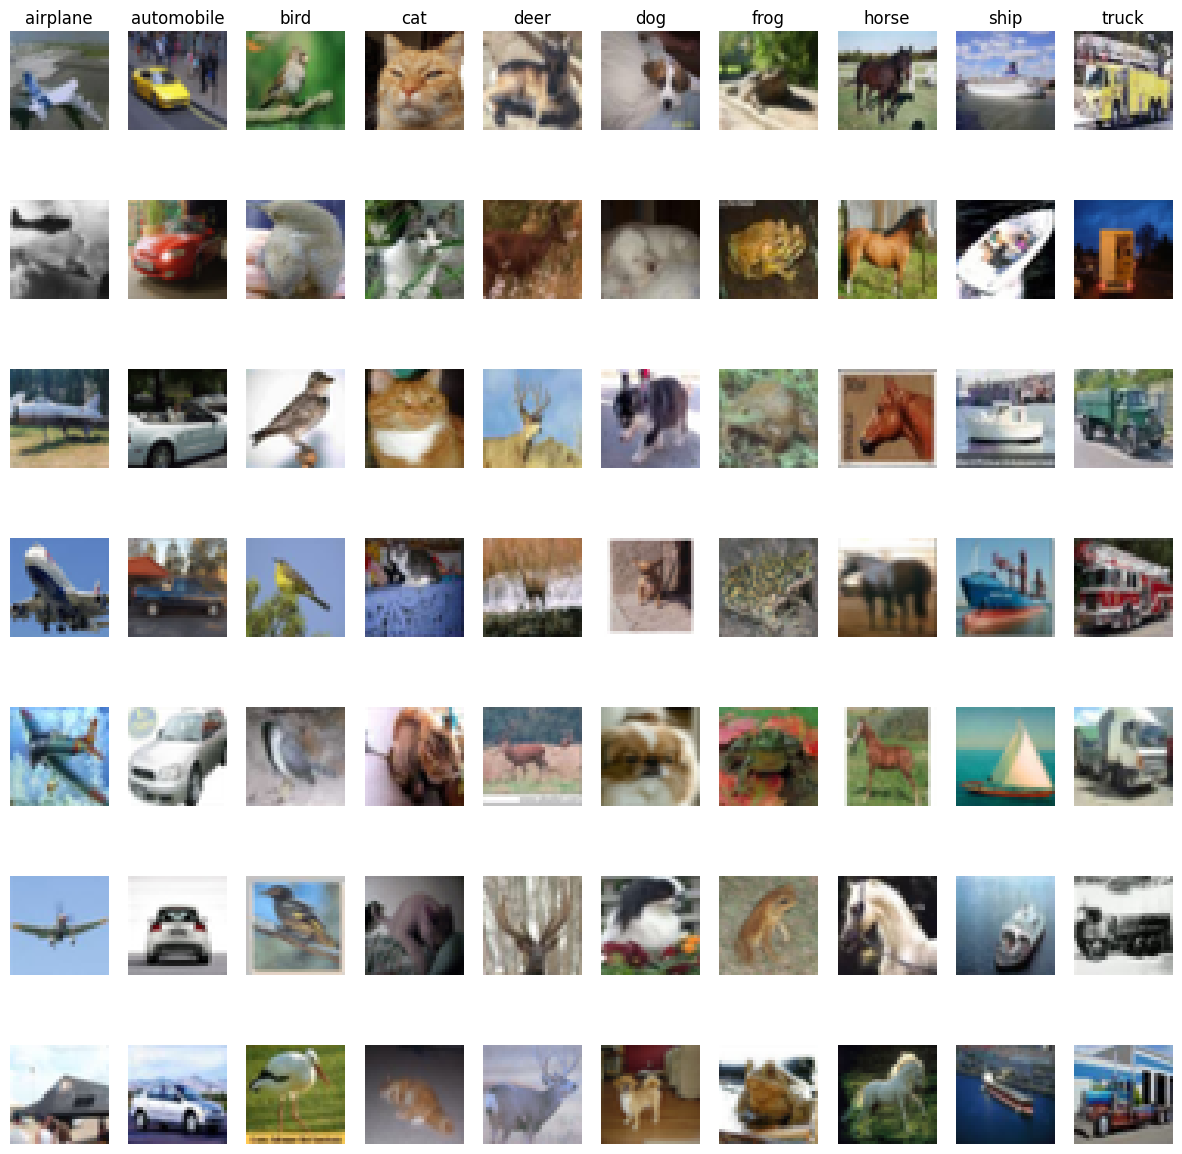

In [8]:
################################################################################
# TODO:                                                                        #
# Explore the dataset and find its classes. Then visualize some examples.      #
# To do so show a few examples of training images from each class              #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Define the CIFAR-10 class names
cifar10_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Number of classes in the dataset
num_classes = len(cifar10_classes)

# Plot a few examples from each class
def visualize_cifar10_data(X_train, y_train, cifar10_classes, num_images_per_class=7):
    """
    Visualizes a few samples of each class from CIFAR-10 training data.

    Arguments:
    X_train -- training data
    y_train -- training labels
    cifar10_classes -- list of class names
    num_images_per_class -- number of images to show for each class
    """
    plt.figure(figsize=(15, 15))
    for i, cls in enumerate(cifar10_classes):
        idxs = np.flatnonzero(y_train == i)
        idxs = np.random.choice(idxs, num_images_per_class, replace=False)
        for j, idx in enumerate(idxs):
            plt_idx = j * num_classes + i + 1
            plt.subplot(num_images_per_class, num_classes, plt_idx)
            plt.imshow(X_train[idx].astype('uint8'))
            plt.axis('off')
            if j == 0:
                plt.title(cls)
    plt.show()

# Visualize the CIFAR-10 data
visualize_cifar10_data(X_train, y_train, cifar10_classes)

pass

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

In [9]:
################################################################################
# TODO:                                                                        #
# Subsample the data for more efficient code execution in this exercise.       #
# You should reduce the number of training and test examples used.             #
# Set num_training to 5000 and num_test to 500.                                #
# Reshape the image data into rows to prepare for processing.                  #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Subsampling the data
num_training = 5000
num_test = 500

# Create the subsampled training data
X_train_sub = X_train[:num_training].reshape(num_training, -1)
y_train_sub = y_train[:num_training]
X_test_sub = X_test[:num_test].reshape(num_test, -1)
y_test_sub = y_test[:num_test]


print(f"X_train_sub shape: {X_train_sub.shape}")
print(f"y_train_sub shape: {y_train_sub.shape}")
print(f"X_test_sub shape: {X_test_sub.shape}")
print(f"y_test_sub shape: {y_test_sub.shape}")

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

X_train_sub shape: (5000, 3072)
y_train_sub shape: (5000,)
X_test_sub shape: (500, 3072)
y_test_sub shape: (500,)


In [10]:
from k_nearest_neighbor import KNearestNeighbor

################################################################################
# TODO:                                                                        #
# Create a kNN classifier instance and call its training method.                #
# Remember that training a kNN classifier is a noop:                           #
# the classifier simply remembers the data and does no further processing.     #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Create a kNN classifier instance
knn = KNearestNeighbor()

# Train the classifier (this just memorizes the training data)
knn.train(X_train_sub, y_train_sub)

pass

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

We would now like to classify the test data with the kNN classifier. Recall that we can break down this process into two steps:

1. First we must compute the distances between all test examples and all train examples.
2. Given these distances, for each test example we find the k nearest examples and have them vote for the label

Lets begin with computing the distance matrix between all training and test examples. For example, if there are **Ntr** training examples and **Nte** test examples, this stage should result in a **Nte x Ntr** matrix where each element (i,j) is the distance between the i-th test and j-th train example.

**Note: For the three distance computations that we require you to implement in this notebook, you may not use the np.linalg.norm() function that numpy provides.**

First, open `k_nearest_neighbor.py` and implement the function `compute_distances_two_loops` that uses a (very inefficient) double loop over all pairs of (test, train) examples and computes the distance matrix one element at a time.

In [11]:
# Open k_nearest_neighbor.py and implement
# compute_distances_two_loops.

# TODO: Test your implementation:
dists = knn.compute_distances_two_loops(X_test_sub)
print(dists.shape)

(500, 5000)


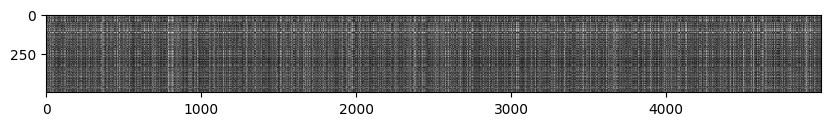

In [12]:
# We can visualize the distance matrix: each row is a single test example and
# its distances to training examples
plt.imshow(dists, interpolation='none')
plt.show()

**Inline Question 1**

Notice the structured patterns in the distance matrix, where some rows or columns are visibly brighter. (Note that with the default color scheme black indicates low distances while white indicates high distances.)

- What in the data is the cause behind the distinctly bright rows?
- What causes the columns?

$\color{pink}{\textit Your Answer:}$

#### Bright Rows:
A bright row means that the test example corresponding to that row is **far** from many or all of the training examples. This could be caused by:
1. **Outliers in the Test Data**: The test example may be very different from all the training examples, leading to high distances (bright colors) for all comparisons with training data. These test examples could represent edge cases or rare instances not well-represented in the training data.
2. **Poor Generalization**: If the training set does not adequately represent the test example’s characteristics, the model might struggle to find close matches in the training data, resulting in higher distances across the row.

#### Bright Columns:
A bright column means that the training example corresponding to that column is **far** from many or all of the test examples. This could be due to:
1. **Outliers in the Training Data**: The training example might be an outlier and significantly different from most of the test examples. This would make its distances to the test data uniformly high.
2. **Unique or Isolated Training Points**: If the training example belongs to a small, distinct group or cluster within the training data that does not overlap well with the test examples, it will appear as distant from many test points.

#### General Causes for the Patterns:
- **Outliers**: Both in the test set (causing bright rows) and in the training set (causing bright columns) can create this pattern. These outliers are significantly different from the other points in terms of feature values, resulting in large distances.
- **Cluster Separation**: If the test and training data come from distinct clusters, or if there are distinct clusters within the training or test data, this could lead to groups of rows or columns being brighter, indicating higher distances between points from different clusters.
- **Underfitting/Overfitting**: If the model is not adequately trained or the training set does not cover the test distribution well, you could see brighter rows/columns as a sign of misalignment between training and test data.




In [13]:
# Use k=1 to predict the labels
y_test_pred = knn.predict_labels(dists, k=1)

# Compute the number of correct predictions
num_correct = np.sum(y_test_pred == y_test_sub)
num_test = y_test_sub.shape[0]

# Compute accuracy
accuracy = num_correct / num_test

# Print the results
print('%d / %d were correct => accuracy: %f' % (num_correct, num_test, accuracy))

137 / 500 were correct => accuracy: 0.274000


You should expect to see approximately `27%` accuracy. Now lets try out a larger `k`, say `k = 5`:

In [14]:
# TODO: Do the same as before with k=5
y_test_pred = knn.predict_labels(dists, k=5)
num_correct = np.sum(y_test_pred == y_test_sub)
num_test = y_test_sub.shape[0]
accuracy = num_correct / num_test

print('%d / %d were correct => accuracy: %f' % (num_correct, num_test, accuracy))

139 / 500 were correct => accuracy: 0.278000


You should expect to see a slightly better performance than with `k = 1`.

**Inline Question 2**

We can also use other distance metrics such as L1 distance.
For pixel values $p_{ij}^{(k)}$ at location $(i,j)$ of some image $I_k$,

the mean $\mu$ across all pixels over all images is $$\mu=\frac{1}{nhw}\sum_{k=1}^n\sum_{i=1}^{h}\sum_{j=1}^{w}p_{ij}^{(k)}$$
And the pixel-wise mean $\mu_{ij}$ across all images is
$$\mu_{ij}=\frac{1}{n}\sum_{k=1}^np_{ij}^{(k)}.$$
The general standard deviation $\sigma$ and pixel-wise standard deviation $\sigma_{ij}$ is defined similarly.

Which of the following preprocessing steps will not change the performance of a Nearest Neighbor classifier that uses L1 distance? Select all that apply. To clarify, both training and test examples are preprocessed in the same way.

1. Subtracting the mean $\mu$ ($\tilde{p}_{ij}^{(k)}=p_{ij}^{(k)}-\mu$.)
2. Subtracting the per pixel mean $\mu_{ij}$  ($\tilde{p}_{ij}^{(k)}=p_{ij}^{(k)}-\mu_{ij}$.)
3. Subtracting the mean $\mu$ and dividing by the standard deviation $\sigma$.
4. Subtracting the pixel-wise mean $\mu_{ij}$ and dividing by the pixel-wise standard deviation $\sigma_{ij}$.
5. Rotating the coordinate axes of the data, which means rotating all the images by the same angle. Empty regions in the image caused by rotation are padded with a same pixel value and no interpolation is performed.

$\color{pink}{\textit Your Answer:}$

1 and 2

$\color{pink}{\textit Your Explanation:}$
- **Subtracting the mean ($\mu$) (Option 1)**:
  Subtracting a constant mean from all pixel values affects all pixels equally. Since L1 distance is based on absolute differences, subtracting the same constant mean from both the training and test images does not change the relative distances between data points. Therefore, the nearest neighbor relationships remain unchanged.

- **Subtracting the per-pixel mean $(\mu_{ij})$ (Option 2)**:
  Similarly, subtracting a per-pixel mean $(\mu_{ij})$, which adjusts each pixel location independently, will affect all images consistently across the dataset. Since both training and test data undergo the same transformation, the L1 distances between images remain consistent, preserving the nearest neighbor relationships.

- **Subtracting the mean $(\mu)$ and dividing by the standard deviation $(\sigma)$ (Option 3)**:
  Dividing by a global standard deviation $(\sigma)$ normalizes the data in a way that affects the scale of the distances. This can change the magnitude of the L1 distances and may alter the nearest neighbors, thus changing the performance.

- **Subtracting the pixel-wise mean $(\mu_{ij})$ and dividing by the pixel-wise standard deviation $(\sigma_{ij})$ (Option 4)**:
  This transformation introduces non-linear scaling (due to pixel-wise standard deviations). While subtracting the per-pixel mean might be fine, dividing by pixel-wise standard deviations can alter the L1 distances significantly, leading to changes in nearest neighbor performance.

- **Rotating the coordinate axes (Option 5)**:
  Rotation transforms the spatial structure of the data, potentially moving features in ways that fundamentally change the L1 distances between points. Although padding is performed, the L1 distance metric depends on the pixel locations, and changing these by rotating the images will alter the nearest neighbor relationships.


In [15]:
# Now lets speed up distance matrix computation by using partial vectorization
# with one loop. Implement the function compute_distances_one_loop and run the
# code below:
dists_one = knn.compute_distances_one_loop(X_test_sub)

# To ensure that our vectorized implementation is correct, we make sure that it
# agrees with the naive implementation. There are many ways to decide whether
# two matrices are similar; one of the simplest is the Frobenius norm.

difference = np.linalg.norm(dists - dists_one, ord='fro')
print('One loop difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

One loop difference was: 0.000000
Good! The distance matrices are the same


In [16]:
# Now implement the fully vectorized version inside compute_distances_no_loops
# and run the code
dists_two = knn.compute_distances_no_loops(X_test_sub)

# check that the distance matrix agrees with the one we computed before:
difference = np.linalg.norm(dists - dists_two, ord='fro')
print('No loop difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

No loop difference was: 0.000000
Good! The distance matrices are the same


Explain how you have implemented compute_distances_no_loops

$\color{pink}{\textit Your Answer:}$

This method computes the Euclidean distance between each test point and each training point without using explicit loops, making it more efficient than the loop-based approaches. The Euclidean distance between two points is calculated using the formula:

$$
d(x, y) = \sqrt{x^2 + y^2 - 2xy}
$$

#### Key Steps:
1. **Squared Sum of Test Points**: Compute the sum of squares for each test point (`X_square`).
2. **Squared Sum of Training Points**: Compute the sum of squares for each training point (`X_train_square`).
3. **Cross Term**: Compute the dot product between the test data and the training data (`cross_term`).
4. **Distance Calculation**: Using the Euclidean distance formula, calculate the distance matrix (`dists`) in a fully vectorized manner.


In [17]:
# Let's compare how fast the implementations are
def time_function(f, *args):
    """
    Call a function f with args and return the time (in seconds) that it took to execute.
    """
    import time
    tic = time.time()
    f(*args)
    toc = time.time()
    return toc - tic

two_loop_time = time_function(knn.compute_distances_two_loops, X_test_sub)
print('Two loop version took %f seconds' % two_loop_time)

one_loop_time = time_function(knn.compute_distances_one_loop, X_test_sub)
print('One loop version took %f seconds' % one_loop_time)

no_loop_time = time_function(knn.compute_distances_no_loops, X_test_sub)
print('No loop version took %f seconds' % no_loop_time)

# You should see significantly faster performance with the fully vectorized implementation!

# NOTE: depending on what machine you're using,
# you might not see a speedup when you go from two loops to one loop,
# and might even see a slow-down.

Two loop version took 59.114093 seconds
One loop version took 45.723777 seconds
No loop version took 1.233673 seconds


### Cross-validation

We have implemented the k-Nearest Neighbor classifier but we set the value k = 5 arbitrarily. We will now determine the best value of this hyperparameter with cross-validation.

In [18]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds = []
y_train_folds = []
################################################################################
# TODO:                                                                        #
# Split up the training data into folds. After splitting, X_train_folds and    #
# y_train_folds should each be lists of length num_folds, where                #
# y_train_folds[i] is the label vector for the points in X_train_folds[i].     #
# Hint: Look up the numpy array_split function.                                #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
# Split the training data into folds
# Flatten the data (both training and test/validation) into shape (num_samples, 3072)
X_train_folds = np.array_split(X_train_sub, num_folds)
y_train_folds = np.array_split(y_train_sub, num_folds)

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# A dictionary holding the accuracies for different values of k that we find
# when running cross-validation. After running cross-validation,
# k_to_accuracies[k] should be a list of length num_folds giving the different
# accuracy values that we found when using that value of k.
k_to_accuracies = {}

################################################################################
# TODO:                                                                        #
# Perform k-fold cross validation to find the best value of k. For each        #
# possible value of k, run the k-nearest-neighbor algorithm num_folds times,   #
# where in each case you use all but one of the folds as training data and the #
# last fold as a validation set. Store the accuracies for all fold and all     #
# values of k in the k_to_accuracies dictionary.                               #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
# Initialize the dictionary to hold accuracies for each k value
k_to_accuracies = {k: [] for k in k_choices}

# Loop over all values of k
for k in k_choices:
    k_to_accuracies[k] = []
    # Loop over the num_folds
    for i in range(num_folds):
        # Prepare the training and validation sets for this fold
        X_train_fold = np.concatenate([X_train_folds[j] for j in range(num_folds) if j != i])
        y_train_fold = np.concatenate([y_train_folds[j] for j in range(num_folds) if j != i])

        X_val_fold = X_train_folds[i]
        y_val_fold = y_train_folds[i]

        # Train the classifier using the training folds
        knn = KNearestNeighbor()
        knn.train(X_train_fold, y_train_fold)

        # Compute the distances between the validation fold and the training folds
        dists = knn.compute_distances_no_loops(X_val_fold)

        # Predict the labels for the validation fold
        y_val_pred = knn.predict_labels(dists, k=k)

        # Compute the accuracy for this fold
        accuracy = np.mean(y_val_pred == y_val_fold)

        # Append the accuracy to the list of accuracies for this value of k
        k_to_accuracies[k].append(accuracy)


# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out the computed accuracies
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))

k = 1, accuracy = 0.263000
k = 1, accuracy = 0.257000
k = 1, accuracy = 0.264000
k = 1, accuracy = 0.278000
k = 1, accuracy = 0.266000
k = 3, accuracy = 0.239000
k = 3, accuracy = 0.249000
k = 3, accuracy = 0.240000
k = 3, accuracy = 0.266000
k = 3, accuracy = 0.254000
k = 5, accuracy = 0.248000
k = 5, accuracy = 0.266000
k = 5, accuracy = 0.280000
k = 5, accuracy = 0.292000
k = 5, accuracy = 0.280000
k = 8, accuracy = 0.262000
k = 8, accuracy = 0.282000
k = 8, accuracy = 0.273000
k = 8, accuracy = 0.290000
k = 8, accuracy = 0.273000
k = 10, accuracy = 0.265000
k = 10, accuracy = 0.296000
k = 10, accuracy = 0.276000
k = 10, accuracy = 0.284000
k = 10, accuracy = 0.280000
k = 12, accuracy = 0.260000
k = 12, accuracy = 0.295000
k = 12, accuracy = 0.279000
k = 12, accuracy = 0.283000
k = 12, accuracy = 0.280000
k = 15, accuracy = 0.252000
k = 15, accuracy = 0.289000
k = 15, accuracy = 0.278000
k = 15, accuracy = 0.282000
k = 15, accuracy = 0.274000
k = 20, accuracy = 0.270000
k = 20, accu

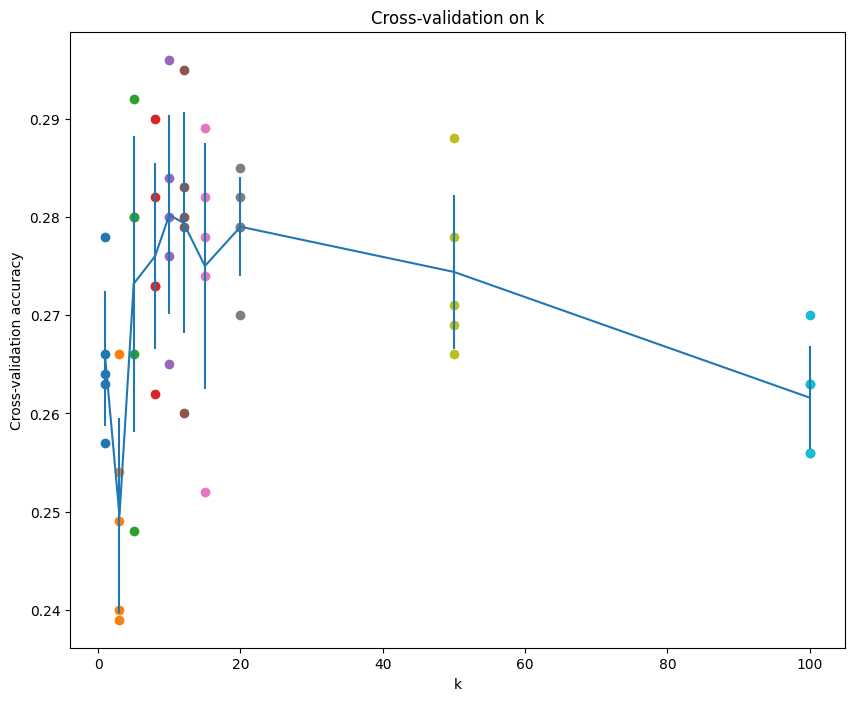

In [19]:
# plot the raw observations
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [23]:
# TODO: Based on the cross-validation results above, choose the best value for k,
# retrain the classifier using all the training data, and test it on the test
# data. You should be able to get above 28% accuracy on the test data.
best_k = k_choices[np.argmax(accuracies_mean)]

# Retrain the classifier using all the training data
knn = KNearestNeighbor()
knn.train(X_train_sub, y_train_sub)

# Compute the distances between the test data and the entire training set
dists_test = knn.compute_distances_no_loops(X_test_sub)

# Predict the labels for the test set using the best k
y_test_pred = knn.predict_labels(dists_test, k=best_k)

# Compute the accuracy on the test data
num_correct = np.sum(y_test_pred == y_test_sub)
num_test = y_test_pred.shape[0]
accuracy = float(num_correct) / num_test

print('%d / %d were correct => accuracy: %f' % (num_correct, num_test, accuracy))

141 / 500 were correct => accuracy: 0.282000


**Inline Question 3**

Which of the following statements about $k$-Nearest Neighbor ($k$-NN) are true in a classification setting, and for all $k$? Select all that apply.
1. The decision boundary of the k-NN classifier is linear.
2. The training error of a 1-NN will always be lower than or equal to that of 5-NN.
3. The test error of a 1-NN will always be lower than that of a 5-NN.
4. The time needed to classify a test example with the k-NN classifier grows with the size of the training set.
5. None of the above.

$\color{pink}{\textit Your Answer:}$

2 and 4

$\color{pink}{\textit Your Explanation:}$

- **Statement 1 (False)**: The decision boundary of the k-NN classifier is not linear. The boundary is highly flexible and depends on the distribution of the data. For instance, in 1-NN, the decision boundary can become very irregular and non-linear as it tries to capture the nearest point for each test case.

- **Statement 2 (True)**: The training error of a 1-NN is always less than or equal to the training error of a 5-NN. This is because 1-NN perfectly memorizes the training data, classifying each point based on its closest neighbor, which is always itself, so the error is minimal. As k increases (e.g., 5-NN), the classifier considers more neighbors, which can increase the training error as it averages over more neighbors.

- **Statement 3 (False)**: The test error of a 1-NN is not guaranteed to be lower than that of a 5-NN. In fact, 1-NN is highly prone to overfitting since it memorizes the training data exactly, which often results in higher test error compared to models with higher values of k (like 5-NN), which generalize better and are less sensitive to noise.

- **Statement 4 (True)**: The time complexity of the k-NN classifier is proportional to the size of the training set because, during classification, the algorithm must compute the distance from the test example to all training examples. As the size of the training set increases, the computation time grows accordingly.
